# CHIRPS-GEFS / CHIRPS / IMERG comparison

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [75]:
import ocha_stratus as stratus
import matplotlib.pyplot as plt
import pandas as pd

from src.datasources import chirps_gefs
from src.constants import *

## For storms specifically

In [3]:
blob_name = f"{PROJECT_PREFIX}/processed/fcast_obsv_combined_stats.parquet"
df_stats = stratus.load_parquet_from_blob(blob_name)

In [4]:
blob_name = f"{PROJECT_PREFIX}/processed/chirps/chirps_stats.parquet"
df_stats_chirps = stratus.load_parquet_from_blob(blob_name)

In [5]:
df_stats = df_stats.merge(df_stats_chirps)

In [6]:
df_stats

,sid,cerf,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,atcf_id,name,mean,q50,...,wind,wind_obsv,q50_obsv,q80_obsv,q90_obsv,q95_obsv,q99_obsv,mean_obsv,year,chirps_roll2_mean
0,2001303N13276,False,5900012,5,165279,0,al152001,MICHELLE,52.256130,42.807594,...,120.0,120.0,76.807495,196.168976,275.528503,316.773743,379.588867,120.507424,2001,44.762631
1,2002258N10300,False,42500,0,37421,0,al102002,ISIDORE,58.365227,55.458720,...,110.0,110.0,40.644997,96.101990,160.391495,390.434479,650.347717,81.429310,2002,62.955593
2,2002265N10315,False,281470,3,37421,0,al132002,LILI,29.202800,26.340120,...,90.0,90.0,37.119995,63.542995,90.831001,112.689499,150.692581,43.857528,2002,23.635686
3,2004223N11301,False,244005,4,1549395,0,al032004,CHARLEY,48.188442,20.040691,...,100.0,105.0,12.170000,44.664997,64.869995,79.344994,107.755745,22.089554,2004,16.215009
4,2004247N10332,False,3245,0,309879,0,al092004,IVAN,63.864970,61.708008,...,145.0,140.0,18.457500,65.580002,139.136993,166.182495,207.636459,38.258119,2004,35.182843
5,2005186N12299,False,2500000,16,2097974,0,al042005,DENNIS,78.946040,80.616330,...,130.0,130.0,87.290009,153.271011,183.921524,224.965729,309.937012,97.973385,2005,61.188364
6,2005289N18282,False,100000,4,1048987,0,al252005,WILMA,25.986856,15.891295,...,135.0,90.0,3.040000,13.497999,24.623499,38.966499,82.392998,35.630949,2005,13.742782
7,2006161N20275,False,268,0,0,0,al012006,ALBERTO,33.027378,8.143184,...,35.0,30.0,35.949997,112.148994,164.188965,191.354996,342.510803,47.141314,2006,52.196036
8,2007297N18300,False,192488,1,705728,0,al162007,NOEL,30.700450,22.132858,...,60.0,50.0,8.742500,64.883003,112.762489,136.426758,219.240021,31.950908,2007,49.714364
9,2008229N18293,False,0,0,0,0,al062008,FAY,52.268467,45.139200,...,65.0,50.0,38.012497,103.079987,133.069504,156.676987,192.376068,55.230145,2008,34.121048


In [7]:
df_stats_corr = df_stats.corr(numeric_only=True)

In [8]:
def plot_rain_comparison(xcol, ycol):
    fig, ax = plt.subplots(dpi=150, figsize=(7, 7))
    df_stats.plot(x=xcol, y=ycol, ax=ax, linewidth=0, legend=False)
    xthresh = df_stats[xcol].quantile(2 / 3)
    ythresh = df_stats[ycol].quantile(2 / 3)

    df_stats["P"] = df_stats[xcol] >= xthresh
    df_stats["TP"] = (df_stats[ycol] >= ythresh) & df_stats["P"]

    tpr = df_stats["TP"].sum() / df_stats["P"].sum()

    ax.axhline(ythresh)
    ax.axvline(xthresh)
    for _, row in df_stats.iterrows():
        ax.annotate(
            row["name"].capitalize() + "\n" + str(row["year"]),
            (row[xcol], row[ycol]),
            ha="center",
            va="center",
        )
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    corr = df_stats_corr.loc[xcol, ycol]
    ax.set_title(f"{xcol}\n{corr=:.02f}\n{tpr=:.02f}")
    return fig, ax

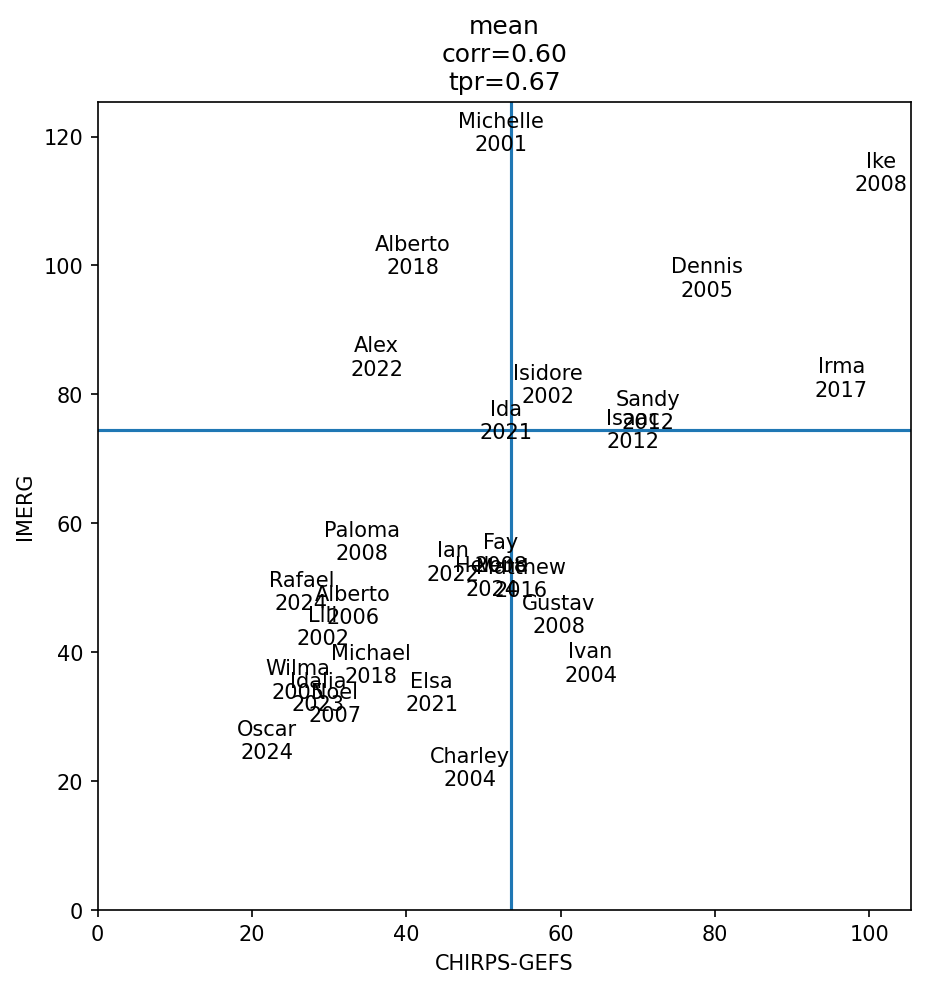

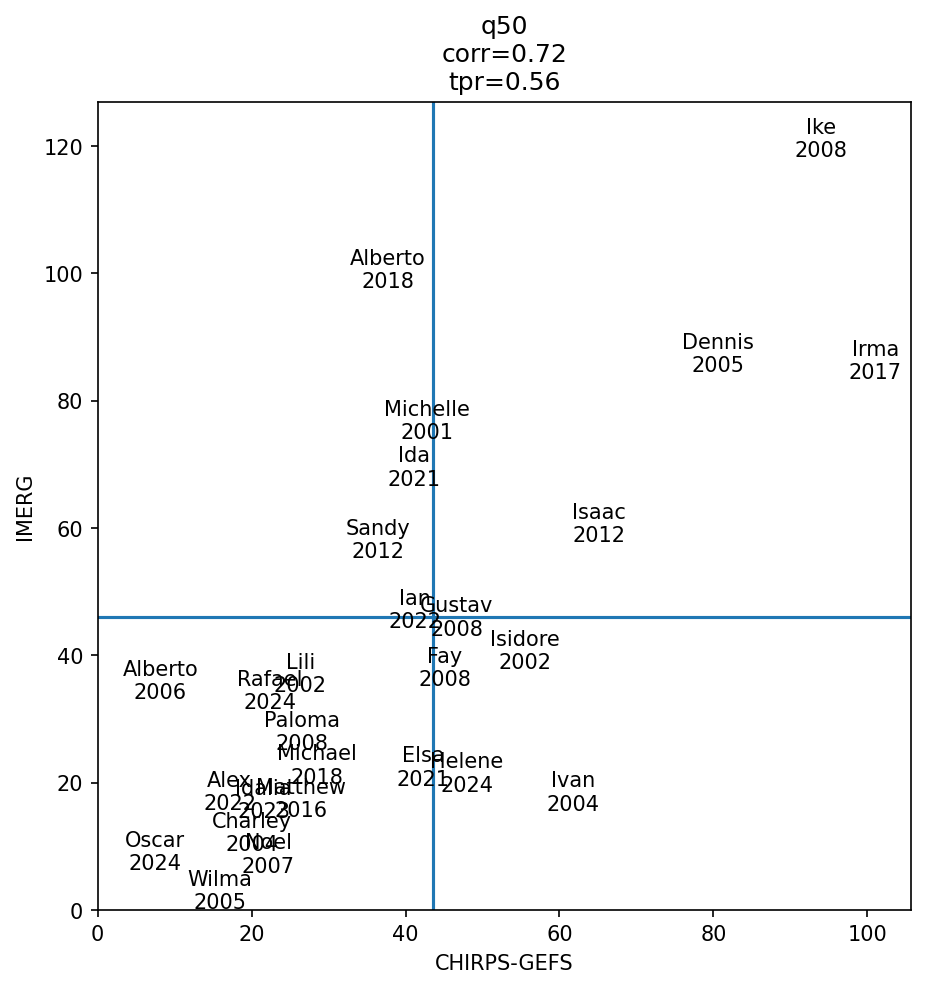

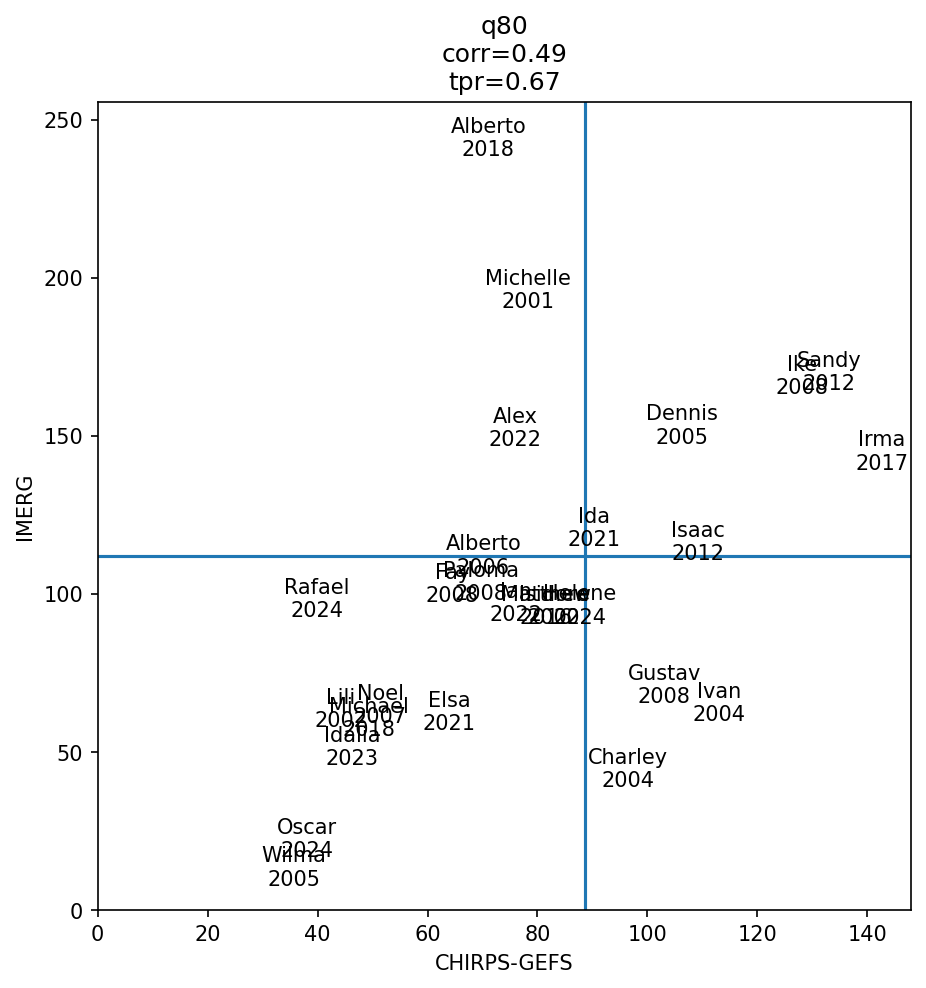

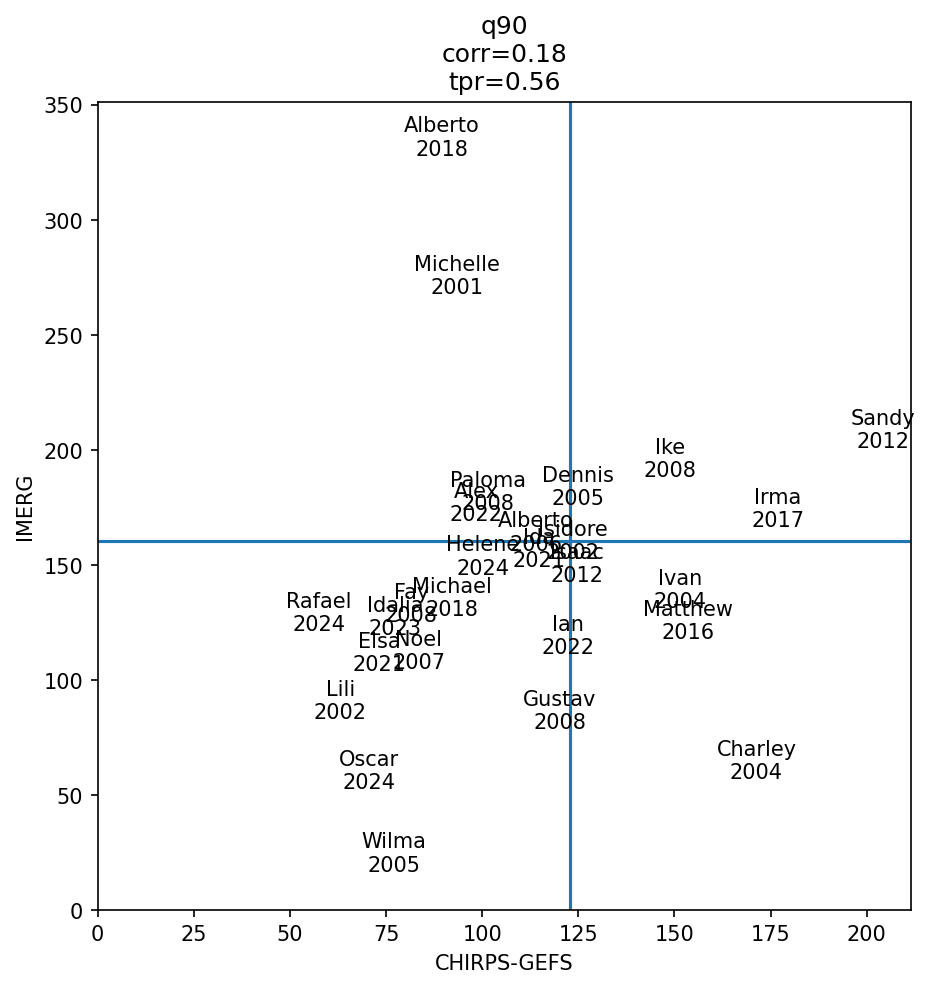

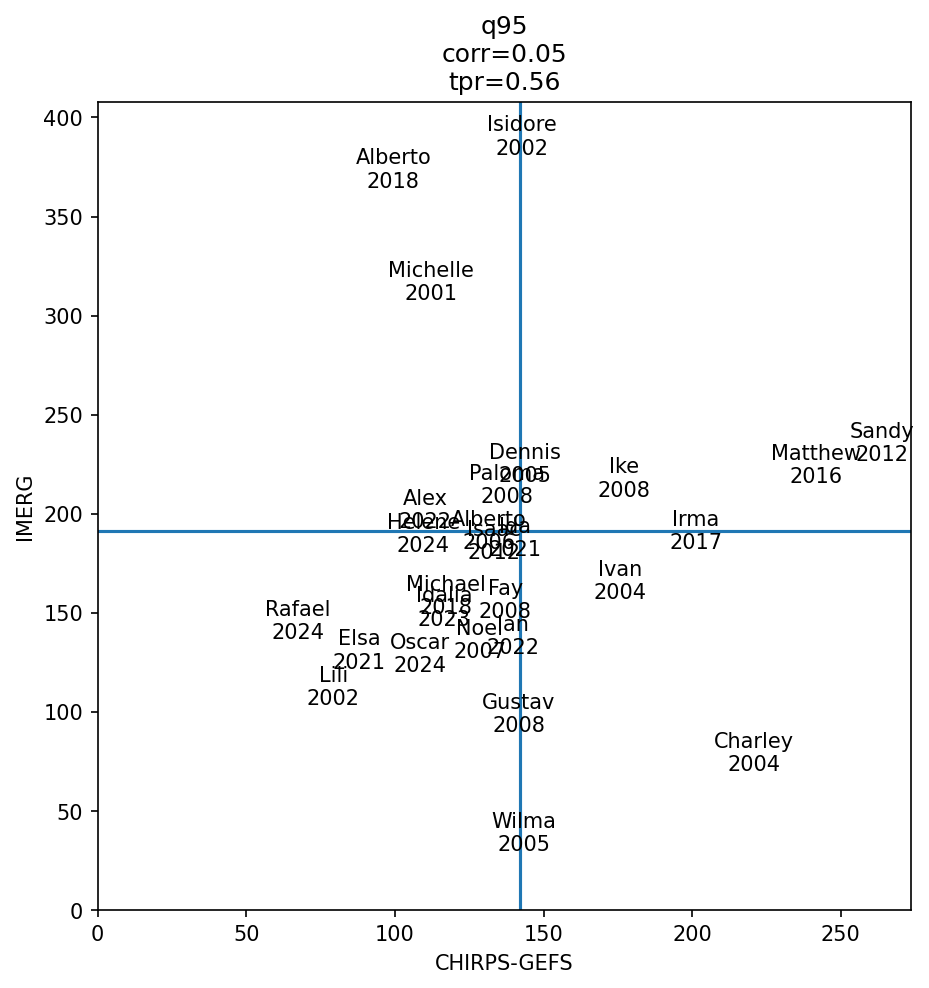

In [9]:
aggs = ["mean"] + [f"q{x}" for x in [50, 80, 90, 95]]

for agg in aggs:
    xcol, ycol = agg, f"{agg}_obsv"
    fig, ax = plot_rain_comparison(xcol, ycol)
    ax.set_xlabel("CHIRPS-GEFS")
    ax.set_ylabel("IMERG")

Text(0, 0.5, 'CHIRPS')

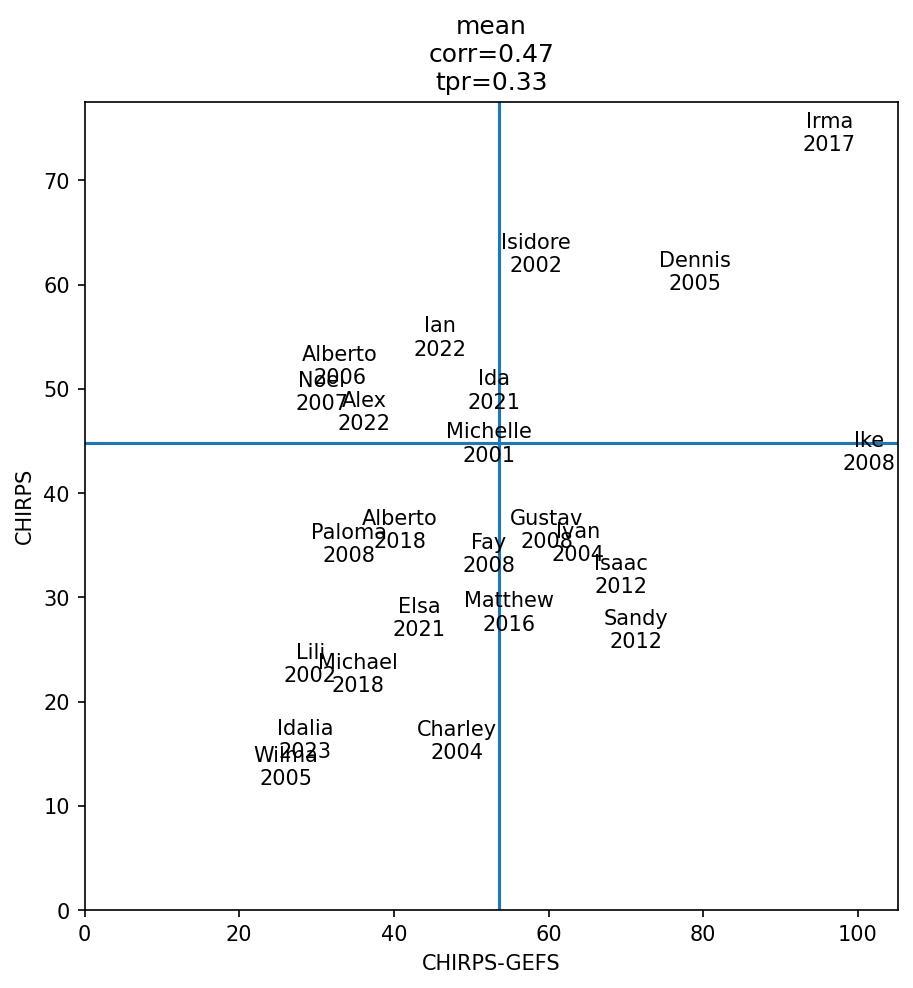

In [10]:
xcol, ycol = "mean", "chirps_roll2_mean"
fig, ax = plot_rain_comparison(xcol, ycol)
ax.set_xlabel("CHIRPS-GEFS")
ax.set_ylabel("CHIRPS")

Text(0, 0.5, 'CHIRPS')

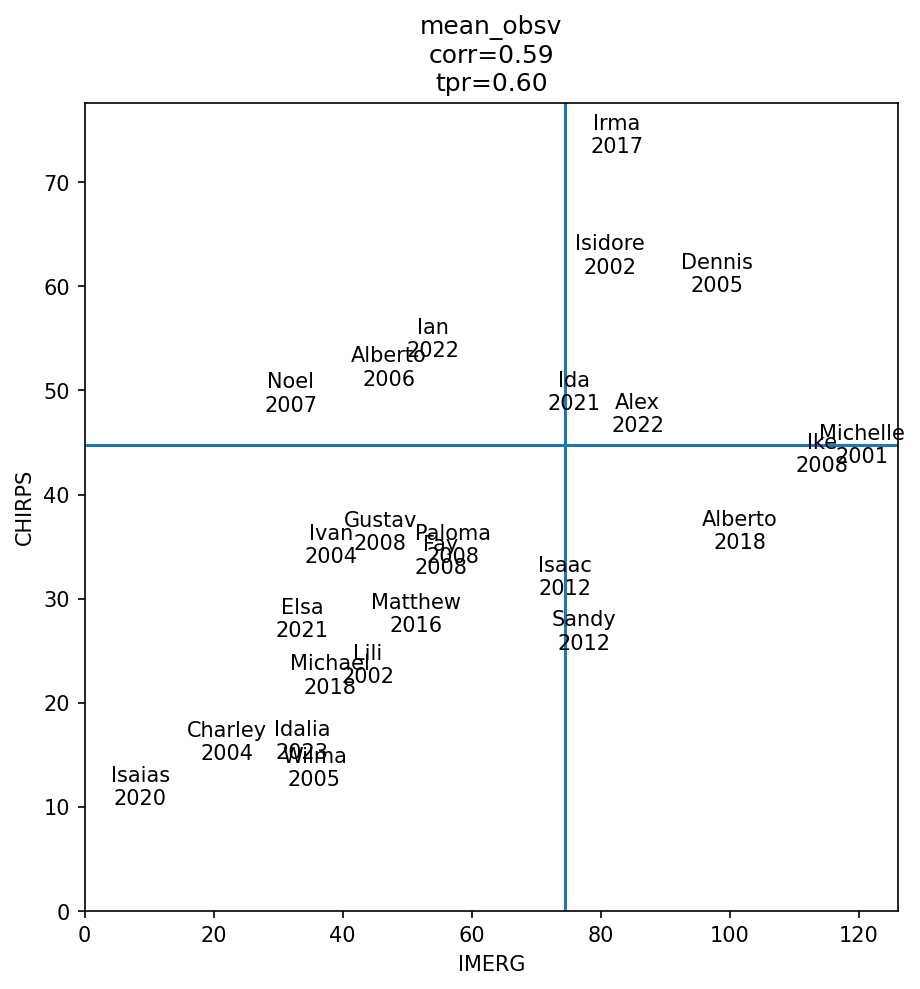

In [11]:
xcol, ycol = "mean_obsv", "chirps_roll2_mean"
fig, ax = plot_rain_comparison(xcol, ycol)
ax.set_xlabel("IMERG")
ax.set_ylabel("CHIRPS")

## In general daily

In [28]:
blob_name = f"{PROJECT_PREFIX}/processed/chirps/20240524_chirps_daily_historical_cuba.csv"
df_daily_chirps = stratus.load_csv_from_blob(blob_name, parse_dates=["date"])
df_daily_chirps = df_daily_chirps[["value", "date"]].rename(
    columns={"date": "valid_date"}
)

In [38]:
df_daily_chirps = df_daily_chirps.sort_values("valid_date")

In [39]:
df_daily_chirps["roll2"] = df_daily_chirps["value"].rolling(2).sum()

In [43]:
df_daily_gefs = chirps_gefs.load_processed_chirps_gefs(variable_name="mean")
df_daily_gefs = df_daily_gefs.drop(columns="variable").rename(
    columns={"value": "roll2"}
)

In [47]:
df_daily = df_daily_chirps.merge(
    df_daily_gefs, on="valid_date", suffixes=("_o", "_f")
)

In [49]:
df_daily["leadtime"] = df_daily["valid_date"] - df_daily["issued_date"]

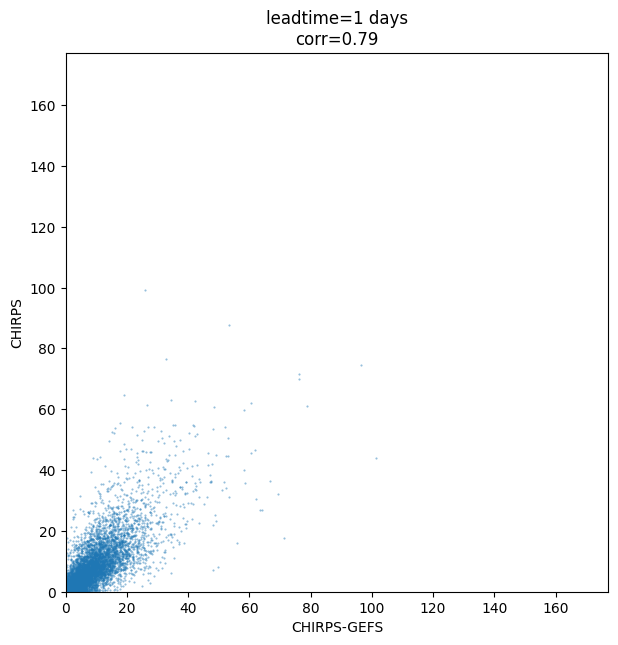

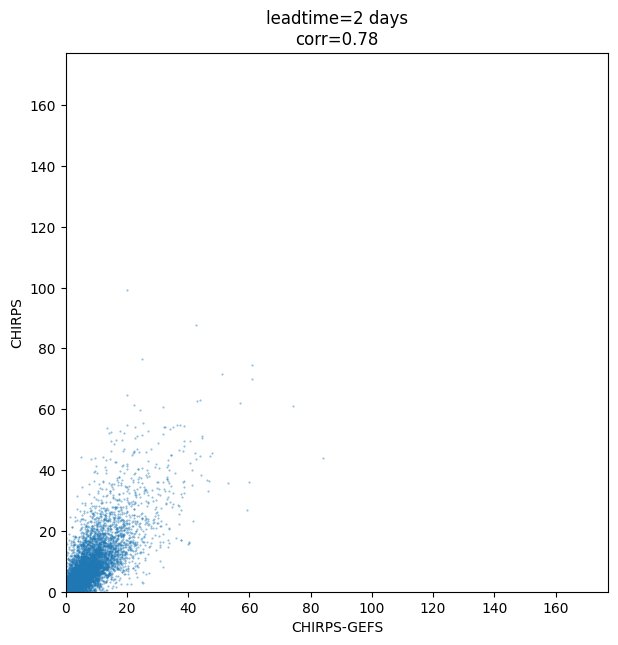

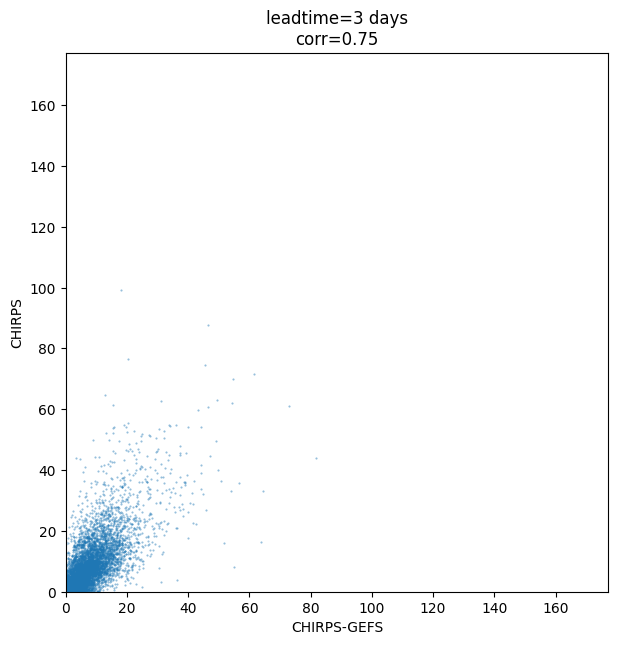

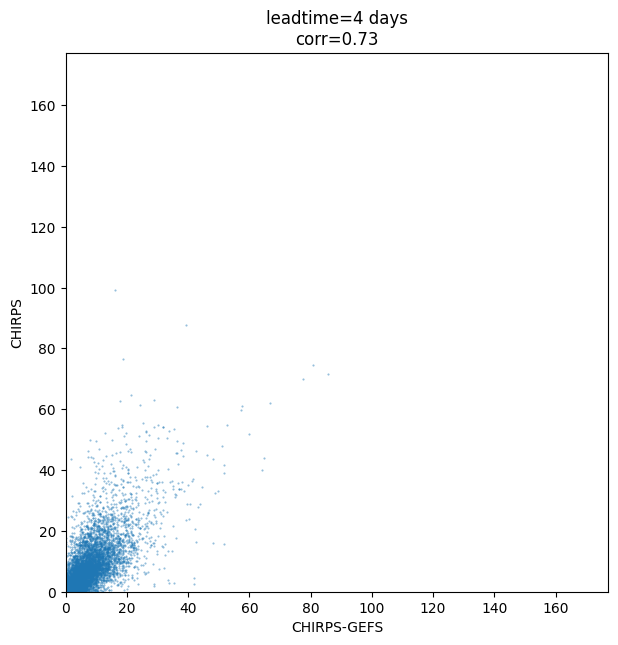

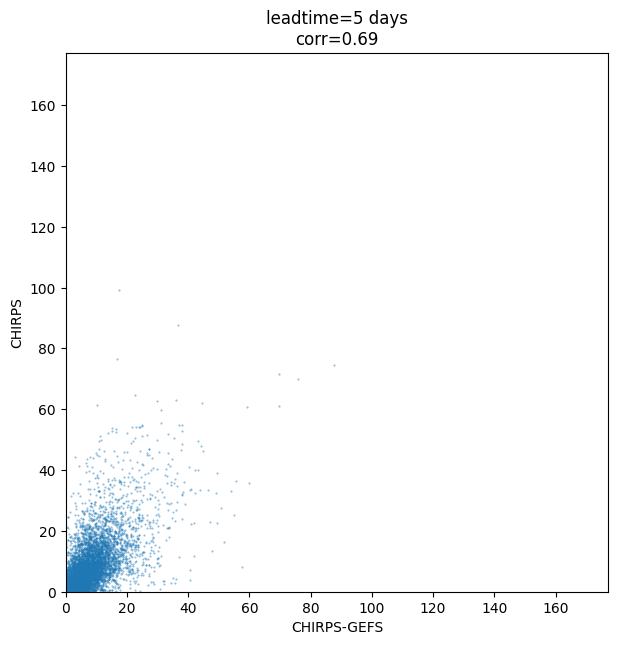

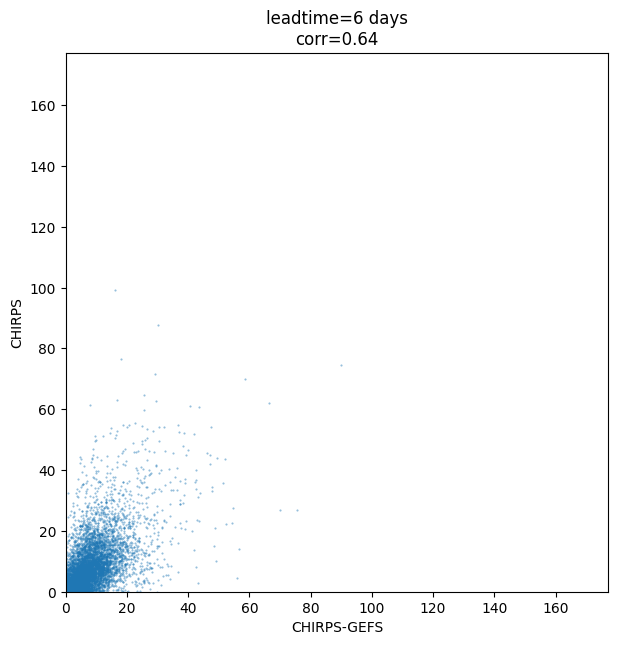

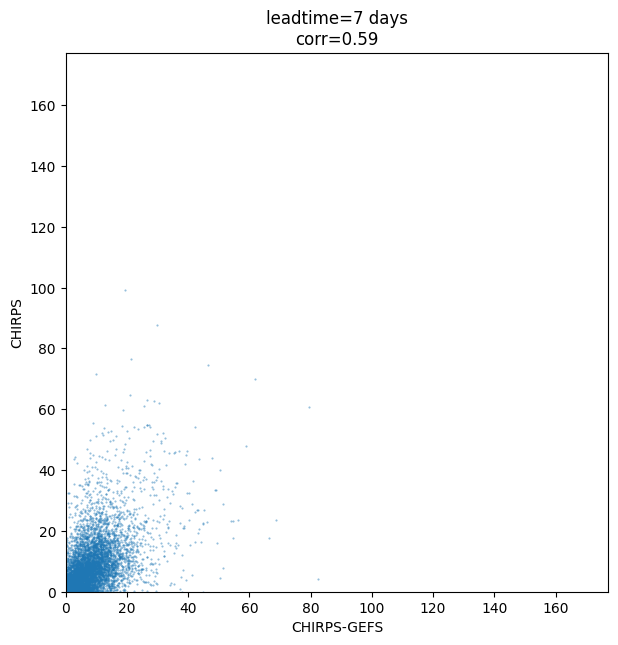

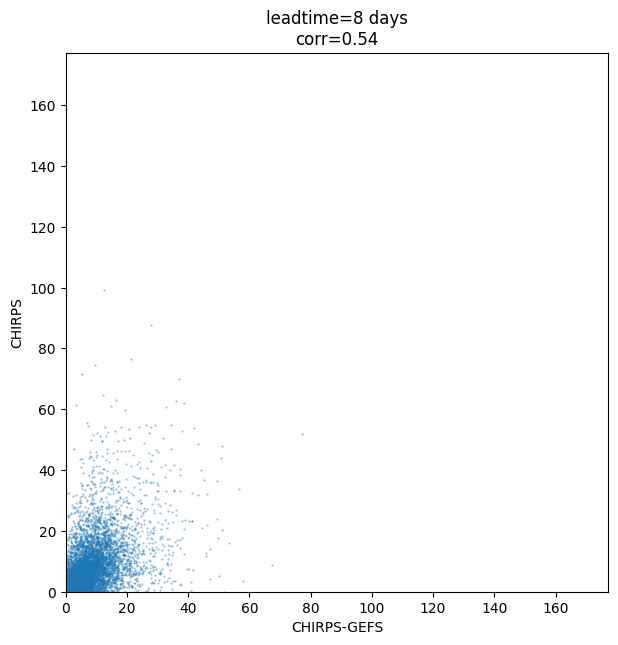

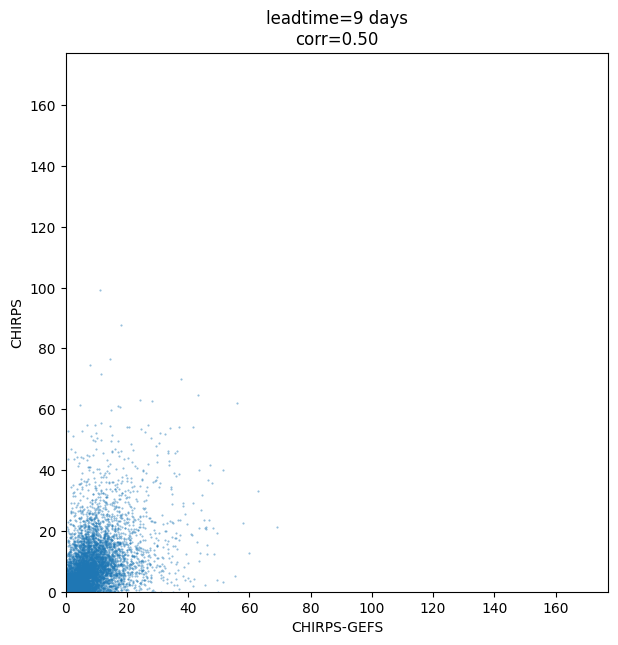

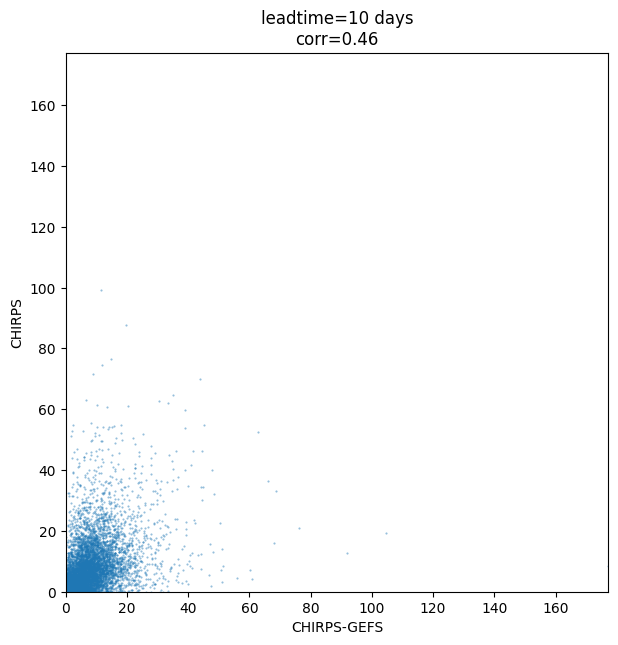

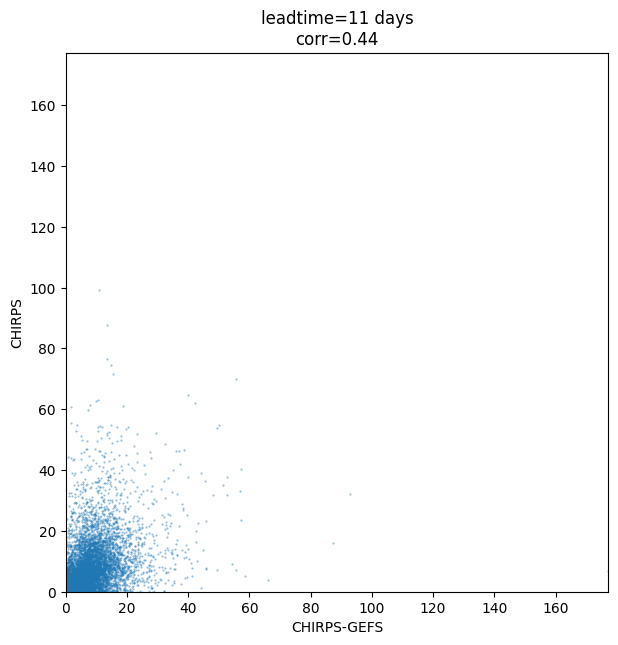

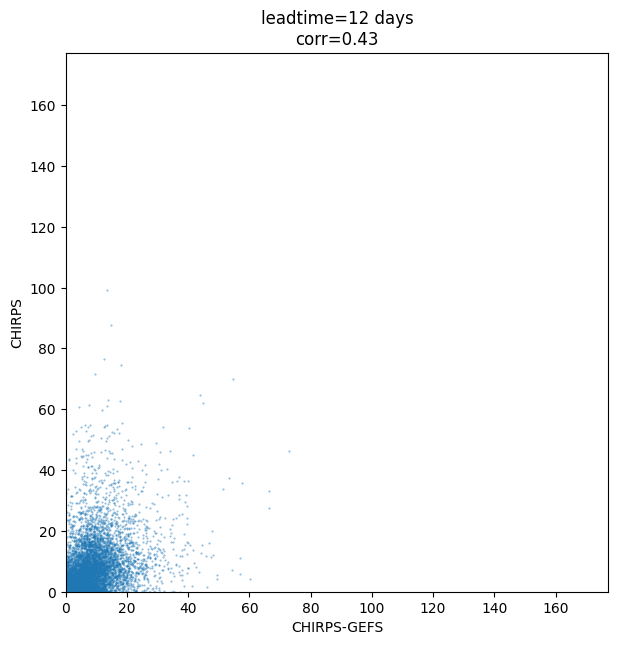

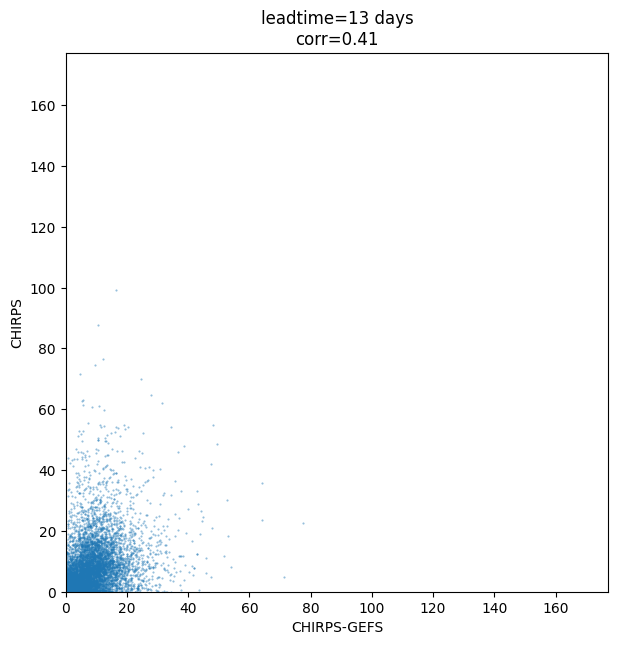

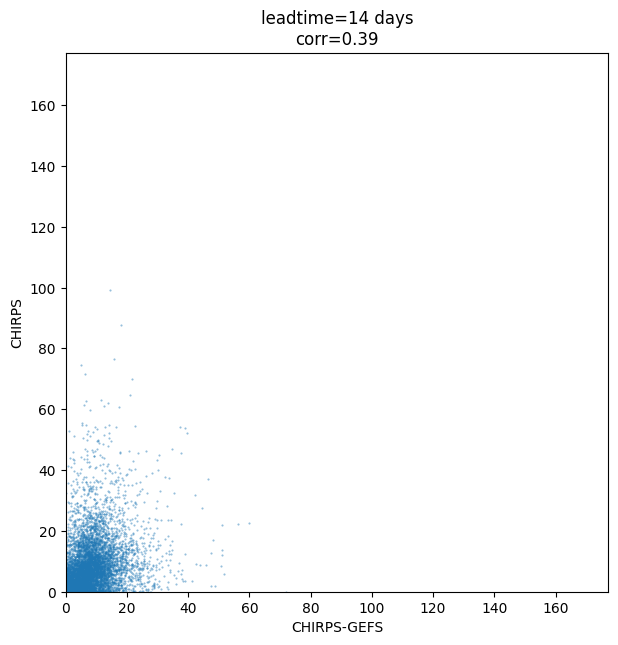

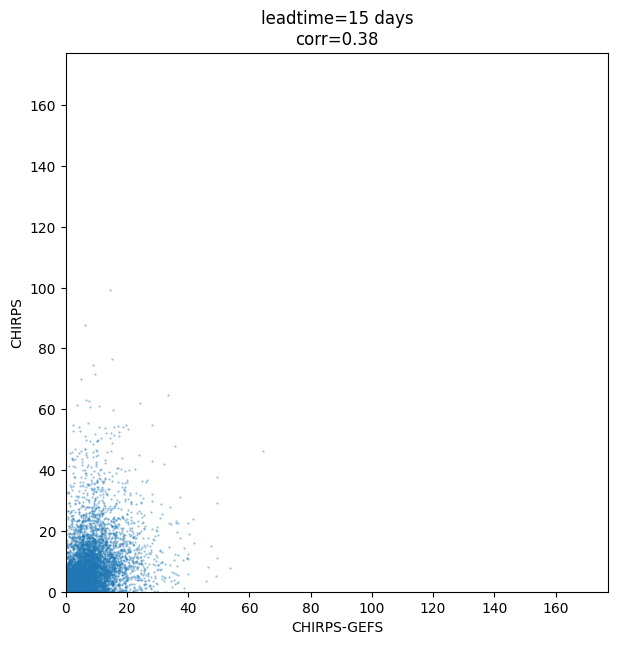

In [83]:
xymax = df_daily[["roll2_f", "roll2_o"]].max().max()

dicts = []

xcol = "roll2_f"
ycol = "roll2_o"

for lt, group in df_daily.groupby("leadtime"):
    if lt.days == 0:
        continue
    fig, ax = plt.subplots(figsize=(7, 7))
    group.plot(
        x=xcol,
        y=ycol,
        ax=ax,
        linewidth=0,
        marker=".",
        markersize=1,
        alpha=0.5,
        legend=False,
    )

    xthresh = group[xcol].quantile(2 / 3)
    ythresh = group[ycol].quantile(2 / 3)

    group["P"] = group[xcol] >= xthresh
    group["TP"] = (group[ycol] >= ythresh) & group["P"]

    tpr = group["TP"].sum() / group["P"].sum()
    corr = group.corr().loc[xcol, ycol]
    ax.set_xlim((0, xymax))
    ax.set_ylim((0, xymax))
    ax.set_xlabel("CHIRPS-GEFS")
    ax.set_ylabel("CHIRPS")
    ax.set_title(f"leadtime={lt.days} days\n{corr=:0.2f}")

    dicts.append({"lt": lt.days, "corr": corr, "tpr": tpr})

In [76]:
df_metrics = pd.DataFrame(dicts)

<Axes: xlabel='lt'>

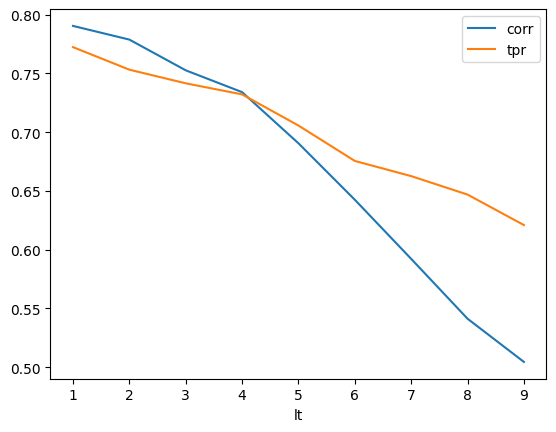

In [81]:
df_metrics[df_metrics["lt"] <= 9].set_index("lt").plot()

<Axes: xlabel='leadtime'>

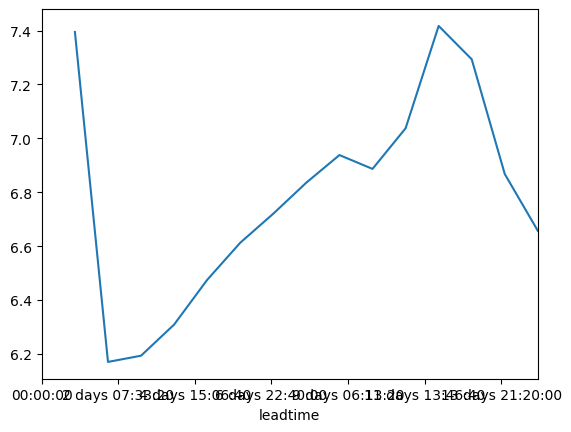

In [94]:
df_daily.groupby("leadtime")["roll2_f"].mean().plot()